<a href="https://colab.research.google.com/github/jchen8000/MLDLwithPython/blob/main/4_09_Artificial_Neural_Network/ANN_Algorithm_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN Algorithm and Implement from Scratch

### Load IRIS Dataset

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, 
                 random_state=1)

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1))

### Define Artificial Neural Network

In [2]:
class ArtificialNeuralNetwork:

    def __init__(self, nodes=[]):
        np.random.seed(27)
        self.theta = self.initialize(nodes)
        self.layers = len(self.theta)
        self.history = []

    def initialize(self, nodes):
        theta = []
        for i in range(1, len(nodes)):
            w = np.random.uniform(-1,1,(nodes[i-1]+1, nodes[i]))
            theta.append(w)
        return theta

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return np.multiply(z, 1-z)

    def cost(self, h, y):
        return (-np.mean(np.sum(np.log(h) * (y), axis=1)))

    def add_intercept(self, x):
        return np.hstack((np.ones((x.shape[0],1)), x))

    def forward_propagation(self, X):
        outputs = [X]
        x_ = X
        for j in range(self.layers):
            x_ = self.add_intercept(x_)
            output = self.sigmoid(np.dot(x_, self.theta[j]))
            outputs.append(output)
            x_ = output
        return outputs

    def back_propagation(self, y, outputs, alpha):
        error = np.matrix(y - outputs[-1]) #output layer (final) error
        for j in range(self.layers, 0, -1):
            curr_out = outputs[j]
            prev_out = self.add_intercept(outputs[j-1])
            delta = np.multiply(error, self.sigmoid_derivative(curr_out))
            self.theta[j-1] += alpha * np.dot(prev_out.T, delta)
            adj_theta = np.delete(self.theta[j-1], [0], axis=0)
            error = np.dot(delta, adj_theta.T) #current layer error
        return self.theta

    def fit(self, X, y, epochs=100, alpha=0.01, verbose=1 ):
        for epoch in range(1, epochs+1):
          outputs = self.forward_propagation(X)
          self.theta = self.back_propagation(y, outputs, alpha)
          if(epoch % 10 == 0):
              accuracy_ = self.accuracy(X_train, y_train)
              cost_ = self.cost( outputs[-1], y_train )              
              self.history.append([accuracy_, cost_])
              if verbose != 0:
                print("Epoch {}".format(epoch), end = ': ')
                print("Accuracy: %.6f"%accuracy_, end = ', ')
                print("Cost: %.6f"%cost_)
        return np.array(self.history)

    def predict(self, X):
        outputs = self.forward_propagation(X)
        f_output = outputs[-1]
        return (f_output == f_output.max(axis=1, keepdims=True)).astype(float)

    def accuracy(self, X, y):
        y_ = self.predict(X)
        acc = np.sum(np.equal(y, y_), axis=1)
        return np.sum(acc == y.shape[1])/y.shape[0]


### Build and Train the ANN

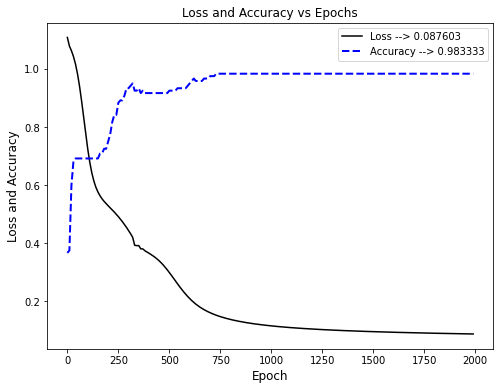

In [3]:
input_layer = len(X_train[0])
output_layer = len(y_train[0])
hidden_layer_1 = 8
hidden_layer_2 = 8
layers = [input_layer, hidden_layer_1, hidden_layer_2, output_layer]
epochs = 2000
ann = ArtificialNeuralNetwork(nodes=layers)
history = ann.fit(X_train, y_train, epochs=epochs, alpha=0.01, verbose=0 )

fig = plt.figure(figsize=(8,6))
plt.title('Loss and Accuracy vs Epochs')
plt.plot(list(range(0, epochs, 10)), history[:,1], color='k', label="Loss --> %f"%history[:,1][-1])
plt.plot(list(range(0, epochs, 10)), history[:,0], color='b', lw=2, ls='--', label="Accuracy --> %f"%history[:,0][-1])
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss and Accuracy', fontsize=12)
plt.legend(loc='best')
plt.savefig("ann_from_scratch.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

### Evaluate Accuracy on Test set

In [4]:
acc = ann.accuracy( X_test, 
                    enc.fit_transform(np.array(y_test).reshape(-1, 1)) )
print("Accuracy:", acc)

Accuracy: 1.0


### Evaluate with sklearn metrics

In [5]:
from sklearn import metrics
y_pred = ann.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.squeeze(np.asarray(y_pred))

a_score = metrics.accuracy_score(y_test, y_pred)
c_matrix = metrics.confusion_matrix(y_test, y_pred)
c_report = metrics.classification_report(y_test, y_pred)
print("Accuracy Score:\n", a_score)
print("Confusion matrix:\n", c_matrix)
print("Classification Report:\n", c_report)

Accuracy Score:
 1.0
Confusion matrix:
 [[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Notes



```
4       8       8      3
  (5x8)   (9x8)   (9x3)
theta
0: (5, 8)
1: (9, 8)
2: (9, 3)

self.theta[j-1] += alpha * np.dot(prevOp.T, delta)
 prevOp     prevOp.T      delta     theta    
(120, 9) -> (9, 120) dot (120, 3) = (9, 3)
(120, 9) -> (9, 120) dot (120, 8) = (9, 8)
(120, 5) -> (5, 120) dot (120, 8) = (5, 8)

wc = np.delete(self.theta[j-1], [0], axis=0)
  wc       theta
(8, 3) <- (9, 3)
(8, 8) <- (9, 8)
(4, 8) <- (5, 8)

error = np.dot(delta, wc.T) #current layer error
 error       delta        wc.T       wc
(120, 8) <- (120, 3) dot (3, 8) <= (8, 3)
(120, 8) <- (120, 8) dot (8, 8) <= (8, 8)
(120, 4) <- (120, 8) dot (8, 4) <= (4, 8)
```
